# Download Dataset from Kaggle

In [1]:
# #!/bin/bash
# !mkdir ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download lava18/google-play-store-apps
# !unzip google-play-store-apps.zip

# Install and Loading Libraries

In [2]:
# Install
!pip install -q pandas numpy matplotlib seaborn kaggle tokenizers tensorflow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 10.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.0a1 which is incompatible.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import ByteLevel

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Embedding, LSTM, GRU, Bidirectional,
                                     Dense, Dropout, Input,
                                     TextVectorization)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import sentencepiece as spm
import subprocess

2025-11-01 20:45:48.728037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762029948.980704      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762029949.047716      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Configurations

# Load & Analyzing Dataset

In [4]:
# Load Dataset (Reviews)
df_reviews = pd.read_csv("/kaggle/input/google-play-store-apps/googleplaystore_user_reviews.csv")
df_reviews.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [5]:
# Load Dataset (Apps)
df_apps = pd.read_csv("/kaggle/input/google-play-store-apps/googleplaystore.csv")
df_apps.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [6]:
def analyze_dataset(df):
    print("=== First 5 Rows ===")
    print(df.head())
    print()
    print("\n=== Last 5 Rows ===")
    print(df.tail())
    print()
    print("\n=== Data Info ===")
    print(df.info())
    print()
    print("\n=== Data Description ===")
    print(df.describe())
    print()
    print("\n=== Missing Values ===")
    print(df.isnull().sum())
    print()
    print("\n=== Duplicate Values ===")
    print(df.duplicated().sum())
    print()
    print("\n=== Unique Values ===")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()}")

In [7]:
# Execution
analyze_dataset(df_reviews)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

=== First 5 Rows ===
                     App                                  Translated_Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
2  10 Best Foods for You                                                NaN   
3  10 Best Foods for You         Works great especially going grocery store   
4  10 Best Foods for You                                       Best idea us   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity  
0  Positive                1.00                0.533333  
1  Positive                0.25                0.288462  
2       NaN                 NaN                     NaN  
3  Positive                0.40                0.875000  
4  Positive                1.00                0.300000  


=== Last 5 Rows ===
                               App Translated_Review Sentiment  \
64290  Houzz Interior Design Ideas               NaN       NaN   
64

In [8]:
# Execution
analyze_dataset(df_apps)

=== First 5 Rows ===
                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0.0   
1  

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


# Dataset Preprocessing

In [9]:
# Cleaning reviews
df_reviews_clean = df_reviews.dropna(subset=['Translated_Review'])
df_reviews_clean.head(5)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [10]:
# Clearning apps csv
df_apps_clean = df_apps.dropna(subset=['Rating'])
df_apps_clean['Rating'] = pd.to_numeric(df_apps_clean['Rating'], errors='coerce')
df_apps_clean = df_apps_clean.dropna(subset=['Rating'])
df_apps_clean.info(5)

<class 'pandas.core.frame.DataFrame'>
Index: 9367 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9367 non-null   object 
 1   Category        9367 non-null   object 
 2   Rating          9367 non-null   float64
 3   Reviews         9367 non-null   object 
 4   Size            9367 non-null   object 
 5   Installs        9367 non-null   object 
 6   Type            9367 non-null   object 
 7   Price           9367 non-null   object 
 8   Content Rating  9366 non-null   object 
 9   Genres          9367 non-null   object 
 10  Last Updated    9367 non-null   object 
 11  Current Ver     9363 non-null   object 
 12  Android Ver     9364 non-null   object 
dtypes: float64(1), object(12)
memory usage: 1.0+ MB


/tmp/ipykernel_19/1841451559.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apps_clean['Rating'] = pd.to_numeric(df_apps_clean['Rating'], errors='coerce')


> Merging `Reviews` With `Apps`

In [11]:
df = pd.merge(df_reviews_clean, df_apps_clean, on="App")

print("Dataframes merged.")
print(f"Shape of merged DataFrame: {df.shape}")
df.head(5)

Dataframes merged.
Shape of merged DataFrame: (72566, 17)


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up
1,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up
2,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up
3,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up
4,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72566 entries, 0 to 72565
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     72566 non-null  object 
 1   Translated_Review       72566 non-null  object 
 2   Sentiment               72566 non-null  object 
 3   Sentiment_Polarity      72566 non-null  float64
 4   Sentiment_Subjectivity  72566 non-null  float64
 5   Category                72566 non-null  object 
 6   Rating                  72566 non-null  float64
 7   Reviews                 72566 non-null  object 
 8   Size                    72566 non-null  object 
 9   Installs                72566 non-null  object 
 10  Type                    72566 non-null  object 
 11  Price                   72566 non-null  object 
 12  Content Rating          72566 non-null  object 
 13  Genres                  72566 non-null  object 
 14  Last Updated            72566 non-null

> Convert `Rating` to Integer values

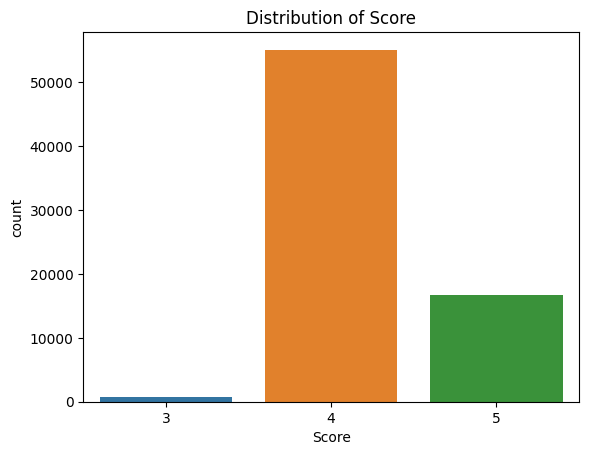

In [13]:
df['Score'] = df['Rating'].round().astype(int)

# Check distribution of Score
sns.countplot(x='Score', data=df); plt.title("Distribution of Score"); plt.show()

In [14]:
df['Score'].value_counts()

Score
4    55068
5    16716
3      782
Name: count, dtype: int64

In [15]:
df['Score'].min(), df['Score'].max()

(3, 5)

The dataset is imbalanced because there are very few reviews with a score less than 3. This can make it difficult for a model to learn what constitutes a "bad" review. To address this, we can reframe the problem as a binary classification task: classifying reviews as either positive (Score 4 and 5) or negative (Score 3).

# Problme Reframing

In [16]:
# converting Score values to 0, 1, 2
# for Average, Good, Excellent
def map_labels(score):
    if score == 3:
        return 0 # Average
    elif score == 4:
        return 1 # Good
    else: # Score == 5
        return 2 # Excellent

df["Label"] = df["Score"].apply(map_labels)
df['Label'].value_counts()

Label
1    55068
2    16716
0      782
Name: count, dtype: int64

> Undersampling

In [17]:
# Find the class with the maximum number of samples
max_class_count = df['Label'].value_counts().max()
print(f"Size of the largest class: {max_class_count}\n")

df_class_0 = df[df['Label'] == 0]
df_class_1 = df[df['Label'] == 1]
df_class_2 = df[df['Label'] == 2]

# Oversampling
df_class_0_over = df_class_0.sample(max_class_count, replace=True, random_state=42)
df_class_1_over = df_class_1.sample(max_class_count, replace=True, random_state=42)
# Class 2 is the majority class, so no oversampling is needed for it.
df_class_2_over = df_class_2

df_balanced = pd.concat([df_class_0_over, df_class_1_over, df_class_2_over], axis=0)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced['Label'].value_counts()

Size of the largest class: 55068



Label
1    55068
0    55068
2    16716
Name: count, dtype: int64

> Text Cleaning

In [18]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_balanced["text_clean"] = df_balanced["Translated_Review"].apply(clean_text)
df_balance = df_balanced.dropna(subset=['text_clean'])

print("Initial class distribution:\n", df_balance['Label'].value_counts())

Initial class distribution:
 Label
1    55068
0    55068
2    16716
Name: count, dtype: int64


# Split X, y

In [19]:
X_text = df_balance['text_clean']
y = df_balance['Label']

# X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

# Tokenization

In [20]:
VOCAB_SIZE = 10000
MAX_SEQ_LENGTH = 60

vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQ_LENGTH
)
print("Adapting TextVectorization layer...")
vectorize_layer.adapt(X_text)
vocabulary = vectorize_layer.get_vocabulary()
word_to_idx = {word: i for i, word in enumerate(vocabulary)}
print("Adaptation complete.")

I0000 00:00:1762029966.466353      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762029966.467049      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Adapting TextVectorization layer...
Adaptation complete.


# Embedding With GloVe

In [21]:
EMBEDDING_DIM = 100
GLOVE_URL = "http://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_FILENAME = "glove.6B.zip"
GLOVE_EMBEDDING_FILE = f"glove.6B.{EMBEDDING_DIM}d.txt"

if not os.path.exists(GLOVE_EMBEDDING_FILE):
    if not os.path.exists(GLOVE_FILENAME):
        response = requests.get(GLOVE_URL)
        with open(GLOVE_FILENAME, "wb") as f:
            f.write(response.content)
        with zipfile.ZipFile(GLOVE_FILENAME, "r") as z:
            z.extractall()

# GloVe Embeddings
glove_embeddings = {}
with open(GLOVE_EMBEDDING_FILE, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        glove_embeddings[values[0]] = np.asarray(values[1:], dtype="float32")

# Creating the embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in word_to_idx.items():
    if i < VOCAB_SIZE:
        vector = glove_embeddings.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

# Build Model

In [22]:
LSTM_UNITS = 64
# Increased dropout rate for stronger regularization
DROPOUT_RATE = 0.6
NUM_CLASSES = len(df_balanced['Label'].unique())

input_layer = Input(shape=(1,), dtype=tf.string, name='input_layer')

vectorize_layer_with_padding = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQ_LENGTH,
    vocabulary=vocabulary
)
vectorized_text = vectorize_layer_with_padding(input_layer)

embedding_layer = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    trainable=False, # Keep it frozen for the initial training phase
    mask_zero=True,
    name='embedding_layer'
)(vectorized_text)

# Added kernel_regularizer and increased recurrent_dropout
bilstm_layer = Bidirectional(
    GRU(LSTM_UNITS,
        recurrent_dropout=0.4,
        kernel_regularizer=l2(0.001))
)(embedding_layer)

# Increased main dropout
dropout_layer = Dropout(DROPOUT_RATE)(bilstm_layer)

# Added kernel_regularizer to the dense layer
dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(dropout_layer)

output_layer = Dense(NUM_CLASSES, activation='softmax')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# Using a slightly lower learning rate can help
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 60)        │          0 │ input_layer[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 60, 100)   │  1,000,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 60)        │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     63,744 │ embedding_layer[… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │         99 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,067,971 (4.07 MB)

 Trainable params: 67,971 (265.51 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

# Training the Model

In [23]:
# Split data into train and validation sets (instead of using validation_split)
X_train, X_val, y_train, y_val = train_test_split(
    X_text.to_numpy(), y.to_numpy(),
    test_size=0.2, # Reserve 20% for validation
    random_state=42,
    stratify=y
)

EPOCHS = 50 # Allow more epochs, EarlyStopping will handle it
BATCH_SIZE = 64
# Increased patience to give the model more room to learn
PATIENCE = 6

callbacks = [
    # Save the best model based on validation loss this time
    ModelCheckpoint('best_review_model.keras', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val), # Provide validation data explicitly
    callbacks=callbacks
)

# --- FINE-TUNING PHASE ---
print("\n--- Phase 2: Fine-Tuning the Embedding Layer ---")

# Load the best model from the initial training phase
best_model = tf.keras.models.load_model('best_review_model.keras')

# Unfreeze the embedding layer
best_model.get_layer('embedding_layer').trainable = True

# Re-compile the model with a VERY low learning rate
best_model.compile(
    optimizer=Adam(learning_rate=1e-5), # Crucial: very low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("Model re-compiled for fine-tuning.")
best_model.summary()

# Continue training for a few more epochs
fine_tune_epochs = 10
# We need a separate EarlyStopping for the fine-tuning phase
fine_tune_patience = 3

history_fine_tune = best_model.fit(
    X_train, y_train,
    epochs=fine_tune_epochs,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[
        # Still save the best model during fine-tuning
        ModelCheckpoint('best_review_model_finetuned.keras', save_best_only=True, monitor='val_loss', mode='min'),
        EarlyStopping(monitor='val_loss', patience=fine_tune_patience, restore_best_weights=True)
    ]
)

Epoch 1/50
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 364s 222ms/step - accuracy: 0.6021 - loss: 1.0419 - val_accuracy: 0.7674 - val_loss: 0.6807
Epoch 2/50
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 352s 222ms/step - accuracy: 0.7539 - loss: 0.6926 - val_accuracy: 0.8180 - val_loss: 0.5470
Epoch 3/50
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 350s 220ms/step - accuracy: 0.7976 - loss: 0.5936 - val_accuracy: 0.8514 - val_loss: 0.4861
Epoch 4/50
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 351s 221ms/step - accuracy: 0.8195 - loss: 0.5381 - val_accuracy: 0.8632 - val_loss: 0.4425
Epoch 5/50
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 349s 220ms/step - accuracy: 0.8341 - loss: 0.5062 - val_accuracy: 0.8702 - val_loss: 0.4175
Epoch 6/50
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 348s 220ms/step - accuracy: 0.8412 - loss: 0.4836 - val_accuracy: 0.8708 - val_loss: 0.4135
Epoch 7/50
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 350s 221ms/step - accuracy: 0.8515 - loss: 0.4575 - val_accuracy: 0.8784 - val_loss: 0.3895
Epoch 8/50
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 350s 221ms/step - ac

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 60)        │          0 │ input_layer[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 60, 100)   │  1,000,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 60)        │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     63,744 │ embedding_layer[… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │         99 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,067,971 (4.07 MB)

 Trainable params: 1,067,971 (4.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 395s 244ms/step - accuracy: 0.9057 - loss: 0.3185 - val_accuracy: 0.9227 - val_loss: 0.2749
Epoch 2/10
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 386s 243ms/step - accuracy: 0.9087 - loss: 0.3073 - val_accuracy: 0.9234 - val_loss: 0.2724
Epoch 3/10
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 386s 244ms/step - accuracy: 0.9089 - loss: 0.3079 - val_accuracy: 0.9241 - val_loss: 0.2711
Epoch 4/10
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 387s 244ms/step - accuracy: 0.9123 - loss: 0.2983 - val_accuracy: 0.9241 - val_loss: 0.2685
Epoch 5/10
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 387s 244ms/step - accuracy: 0.9135 - loss: 0.2985 - val_accuracy: 0.9257 - val_loss: 0.2662
Epoch 6/10
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 390s 246ms/step - accuracy: 0.9151 - loss: 0.2944 - val_accuracy: 0.9259 - val_loss: 0.2643
Epoch 7/10
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 390s 246ms/step - accuracy: 0.9154 - loss: 0.2918 - val_accuracy: 0.9272 - val_loss: 0.2627
Epoch 8/10
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 389s 245ms/step - ac

# Evaluation

In [24]:
# Load the best model from the fine-tuning phase
final_model = tf.keras.models.load_model('best_review_model_finetuned.keras')

# Create the held-out test set from the original balanced data
# (This assumes X_text and y are from the full df_balanced)
_, X_test, _, y_test = train_test_split(
    X_text.to_numpy(), y.to_numpy(),
    test_size=0.2, # Use the same test_size as the initial split
    random_state=42,
    stratify=y
)


test_loss, test_accuracy = final_model.evaluate(X_test, y_test)
print(f"\nFinal Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

# ... (The rest of your evaluation code for classification_report remains the same) ...
y_pred_probs = final_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Re-create label encoder for report labels
le = LabelEncoder()
le.fit(df_balanced['Label'])
# Convert the inverse transformed labels to a list of strings
target_names = [str(label) for label in le.inverse_transform(np.unique(y_test))]
print("\nClassification Report (on Test Data):")
print(classification_report(y_test, y_pred, target_names=target_names))

793/793 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - accuracy: 0.9293 - loss: 0.2600

Final Test Accuracy: 92.97%
Final Test Loss: 0.2577
793/793 ━━━━━━━━━━━━━━━━━━━━ 47s 58ms/step

Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11014
           1       0.88      0.97      0.92     11014
           2       0.88      0.58      0.70      3343

    accuracy                           0.93     25371
   macro avg       0.92      0.85      0.87     25371
weighted avg       0.93      0.93      0.92     25371

